In [254]:
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO, A2C, DQN
from sb3_contrib import RecurrentPPO

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import random

from sympy import Matrix, symbols, eye, KroneckerProduct

import warnings

# Suppress RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [256]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Make sure to enable GPU in the runtime settings.")

GPU is not available. Make sure to enable GPU in the runtime settings.


In [333]:
######################################
# Configuration and Hyperparameters
######################################

LEARNING_RATE = 1e-4
ALPHA = 0.49  # Leakage weight
BETA = 0.02   # Closeness weight
GAMMA = 0.49  # Unitarity weight
SEQUENCE_LENGTH = 100  # Number of compositions (minimum is 21)

In [334]:
from stable_baselines3.common.callbacks import BaseCallback
import pickle

class InfoCallback(BaseCallback):
    """
    Custom callback for logging environment-specific information after each episode
    when using vectorized environments.
    """
    def __init__(self, verbose=0):
        super(InfoCallback, self).__init__(verbose)
        self.leakage_log = []
        self.closeness_log = []
        self.unitarity_log = []
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_rollout_end(self) -> None:
        """
        Called after each rollout collection (one training iteration).
        Place any summary logging here if needed.
        """
        pass

    def _on_step(self) -> bool:
        """
        Called at every environment step. With multiple environments,
        self.locals['dones'] and self.locals['infos'] have length = number_of_envs.
        """
        dones = self.locals['dones']  # list[bool], length = number_of_envs
        infos = self.locals['infos']  # list[dict], length = number_of_envs

        for env_idx, done in enumerate(dones):
            if done:
                info = self.locals['infos'][env_idx]
                
                
                # Extract environment-specific metrics from info
                leakage = info.get("leakage", None)
                closeness_error = info.get("closeness_error", None)
                unitarity_error = info.get("unitarity_error", None)
                final_reward = info.get("final_reward", None)
                current_step = info.get("current_step", None)

                # Append them to the logs if available
                if leakage is not None:
                    self.leakage_log.append(leakage)
                if closeness_error is not None:
                    self.closeness_log.append(closeness_error)
                if unitarity_error is not None:
                    self.unitarity_log.append(unitarity_error)
                if final_reward is not None:
                    self.episode_rewards.append(final_reward)
                if current_step is not None:
                    self.episode_lengths.append(current_step)

        # Return True to indicate the training can go on
        return True
    
    def save_callback_data(self, path):
        # Note that this function is currently broken
        """
        Save the callback's data to a file.
        :param path: Path to the file where the data will be saved.
        """
        data = {
            "leakage_log": self.leakage_log,
            "closeness_log": self.closeness_log,
            "unitarity_log": self.unitarity_log,
            "episode_rewards": self.episode_rewards,
            "episode_lengths": self.episode_lengths,
        }
        with open(path, "wb") as f:
            pickle.dump(data, f)

    def load_callback_data(self, path):
        # Note that this function is currently broken
        """
        Load the callback's data from a file.
        :param path: Path to the file where the data is saved.
        """
        with open(path, "rb") as f:
            data = pickle.load(f)
        self.leakage_log = data["leakage_log"]
        self.closeness_log = data["closeness_log"]
        self.unitarity_log = data["unitarity_log"]
        self.episode_rewards = data["episode_rewards"]
        self.episode_lengths = data["episode_lengths"]


In [335]:
def direct_sum(A, B):

    # Initially the program utilized symbolic manipulation in order to reduce computational overhead
    # But we decided to remove this as it didn't improve performance signifigantly
    # Thus this function needs cleaning

    # Helper function to convert input to a SymPy Matrix
    def to_matrix(x):
        if isinstance(x, Matrix):
            return x
        else:
            # Assume x is a scalar, convert to 1x1 Matrix
            return Matrix([[x]])

    # Convert inputs to matrices
    A_matrix = to_matrix(A)
    B_matrix = to_matrix(B)

    # Check if A_matrix is square
    if A_matrix.rows != A_matrix.cols:
        raise ValueError(f"Matrix A is not square: {A_matrix.rows}x{A_matrix.cols}")

    # Check if B_matrix is square
    if B_matrix.rows != B_matrix.cols:
        raise ValueError(f"Matrix B is not square: {B_matrix.rows}x{B_matrix.cols}")

    # Dimensions
    N = A_matrix.rows
    M = B_matrix.rows

    # Create a zero matrix of size (N+M) x (N+M)
    C = Matrix.zeros(N + M, N + M)

    # Assign A_matrix to the upper-left block
    C[:N, :N] = A_matrix

    # Assign B_matrix to the lower-right block
    C[N:N+M, N:N+M] = B_matrix

    return C

def tensor_product(A, B):
    return KroneckerProduct(A, B)

In [336]:
# R matrix
R_matrix = np.array([
    [ np.exp(-4j * np.pi / 5), 0                      ],
    [ 0                      , np.exp(3j * np.pi / 5) ]
])

R_tt1 = symbols("R_tt1")  # Top-left diagonal
R_ttt = symbols("R_ttt")  # Bottom-right diagonal

sym_R = Matrix([
    [R_tt1, 0],
    [0, R_ttt]
])

# F matrix
phi = (1 + np.sqrt(5)) / 2  # Golden ratio
F_matrix = np.array([
    [ 1/phi          , np.sqrt(1/phi) ],
    [ np.sqrt(1/phi) , -1/phi         ]
])

F_11 =  symbols("F_11")
F_12 =  symbols("F_12")
F_21 =  symbols("F_21")
F_22 =  symbols("F_22")

sym_F = Matrix([
    [F_11, F_12],
    [F_21, F_22]
])

# Substitution dictionary
subs = {
    R_tt1: R_matrix[0, 0],
    R_ttt: R_matrix[1, 1],
    F_11: F_matrix[0, 0],
    F_12: F_matrix[1, 0],
    F_21: F_matrix[0, 1],
    F_22: F_matrix[1, 1]
}

# Permutation matrix
I_2 = eye(2)

I_5 = eye(5)
I_5.row_swap(0, 3)
P14 = I_5


In [337]:
# Braid representations

rho_1 = direct_sum(R_ttt, tensor_product(sym_R, I_2).doit())

rho_2 = direct_sum(R_ttt, tensor_product(sym_F * sym_R * sym_F, I_2).doit())

rho_3 = P14 * direct_sum(R_ttt, direct_sum(sym_R, sym_F * sym_R * sym_F)) * P14

rho_4 = direct_sum(R_ttt, tensor_product(I_2, sym_F * sym_R * sym_F).doit())

rho_5 = direct_sum(R_ttt, tensor_product(I_2, sym_R).doit())

# CNOT gate
cnot_gate = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

In [338]:
class GateApproxEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, braid_gates, target_gate, subs, max_length,
                 alpha, beta, gamma, local_equivalence_class=False):
        super(GateApproxEnv, self).__init__()

        self.max_length = max_length
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.local_equivalence_class = local_equivalence_class

        # Precompute numeric versions of braid_gates
        self.braid_gates = []
        for g in braid_gates:
            g_evaluated = g.subs(subs).evalf()
            if any(sym.is_symbol for sym in g_evaluated):
                raise ValueError("Not all symbols substituted in a braid gate.")
            self.braid_gates.append(np.array(g_evaluated.tolist(), dtype=complex))

        # Precompute numeric target gate
        t_evaluated = target_gate.subs(subs).evalf()
        if any(sym.is_symbol for sym in t_evaluated):
            raise ValueError("Not all symbols substituted in target_gate.")
        self.target_gate = np.array(t_evaluated.tolist(), dtype=complex)

        # Action space: One action per braid gate
        self.action_space = spaces.Discrete(len(self.braid_gates))

        # Observation: Flattened real+imag parts of the 5x5 gate = 50-dim vector
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(50,), dtype=np.float64)

        self.reset_composition()

    def reset_composition(self):
        """Initialize the gate composition as a numeric 5x5 identity matrix."""
        self.current_composition = np.eye(5, dtype=complex)
        self.current_length = 0
        self.gate_stack = []

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.reset_composition()
        self.current_step = 0

        # Randomize the episode length between 1 and max_length
        self.random_episode_length = random.randint(1, self.max_length)

        # Compute initial errors (for reward shaping)
        leak_err, uni_err, close_err, _ = self.compute_reward()
        self.prev_leakage = leak_err
        self.prev_unitarity_error = uni_err
        self.prev_closeness_error = close_err

        # Store a "prev total error" to measure improvement
        self.prev_total_error = (self.alpha * leak_err 
                                 + self.beta * close_err 
                                 + self.gamma * uni_err)

        return self._get_obs(), {}
    
    def take_action(self, action):
        if self.current_length < self.max_length:
            # Numeric matrix multiplication only
            self.current_composition = self.current_composition @ self.braid_gates[action]
            self.gate_stack.append(f"{action}")
            self.current_length += 1
        else:
            print("Warning: Maximum composition length reached. No action taken.")

    def compute_reward(self):
        # Current composition is already numeric
        M = self.current_composition
        T = self.target_gate

        # Leakage: abs(M[0,0])
        leakage = np.abs(M[0,0])
        # Avoid dividing by zero if leakage is extremely small:
        if leakage < 1e-12:
            leakage = 1e-12
        leakage_error = 1.0 / leakage

        # Extract 4x4 submatrix
        M_4x4 = M[1:5, 1:5]

        # Unitarity check
        UdagU = M_4x4.conjugate().T @ M_4x4
        unitarity_error = self.schatten_p_norm(UdagU - np.eye(4), 1)

        # Closeness to target
        if self.local_equivalence_class:
            closeness_error = self.local_equivalence_distance(T, M_4x4)
        else:
            # Schatten 2-norm difference between normalized gates
            A_norm = self.schatten_p_norm(M_4x4, 2)
            T_norm = self.schatten_p_norm(T, 2)

            if A_norm < 1e-12:  # safeguard
                A_norm = 1e-12
            if T_norm < 1e-12:
                T_norm = 1e-12

            A_normalized = M_4x4 / A_norm
            T_normalized = T / T_norm
            closeness_error = self.schatten_p_norm(A_normalized - T_normalized, 2)

        # Reward (negative weighted sum)
        reward = - (self.alpha * leakage_error + self.beta * closeness_error + self.gamma * unitarity_error)
        
        return float(leakage), float(closeness_error), float(unitarity_error), float(reward)
    
    def step(self, action):

        old_total_error = self.prev_total_error

        # 2. Take action
        self.take_action(action)
        self.current_step += 1

        # 3. Compute new error
        leakage, closeness_error, unitarity_error, combined_reward = self.compute_reward()
        new_total_error = (self.alpha * (1.0 / leakage) + self.beta * closeness_error + self.gamma * unitarity_error)

        # 4. Provide incremental reward for improvement
        # If we reduced total_error, that's an improvement => positive reward
        improvement = old_total_error - new_total_error
        step_reward = improvement 

        # Update stored "previous" values for next step
        self.prev_leakage = leakage
        self.prev_unitarity_error = unitarity_error
        self.prev_closeness_error = closeness_error
        self.prev_total_error = new_total_error

        terminated = (self.current_step >= self.random_episode_length)
        truncated = False

        info = {}

        # 5. If the episode terminates, add a final reward that reflects
        #    the final composition's closeness to target
        if terminated:
            step_reward += combined_reward

            info = {
                "current_step": self.current_step,
                "gate_stack": self.gate_stack.copy(),
                "leakage": leakage,
                "closeness_error": closeness_error,
                "unitarity_error": unitarity_error,
                "combined_reward": combined_reward,
                "improvement": improvement,
                "final_reward": step_reward if terminated else None
            }

        obs = self._get_obs()

        return obs, step_reward, terminated, truncated, info

    def _get_obs(self):
        # current_composition is numeric, just flatten
        M = self.current_composition
        obs = np.concatenate([M.real.flatten(), M.imag.flatten()])
        return obs

    """
    def schatten_p_norm(self, T, p):

        # Compute |T| = sqrt(T^† T)
        abs_T = sqrtm(T.conj().T @ T)

        # Compute |T|^p
        abs_T_p = np.linalg.matrix_power(abs_T, p)

        # Compute the trace of |T|^p
        trace_value = np.trace(abs_T_p)

        # Compute the Schatten p-norm
        schatten_norm = np.real(trace_value)**(1/p)

        return schatten_norm
    """

    def schatten_p_norm(self, T, p):
        """
        Compute the Schatten p-norm of a matrix T using its singular values.
        """
        # Ensure T is a NumPy array
        T = np.array(T, dtype=complex)

        # Compute singular values of T
        singular_values = np.linalg.svd(T, compute_uv=False)

        # Compute Schatten p-norm
        if p == np.inf:  # Special case for p = infinity
            schatten_norm = np.max(singular_values)
        elif p == 1:  # Special case for p = 1 (nuclear norm)
            schatten_norm = np.sum(singular_values)
        else:
            # General case for arbitrary p
            schatten_norm = (np.sum(singular_values**p))**(1/p)

        return schatten_norm



    def compute_makhlin_invariants(self, U):

        i = 1j  # Complex unit (sqrt(-1))
        Q = (1 / np.sqrt(2)) * np.array([
            [1,  0,  0,  i],
            [0,  i,  1,  0],
            [0,  i, -1,  0],
            [1,  0,  0, -i]
        ], dtype=complex)

        # Compute U_B = Q^\dagger U Q
        U_B = Q.conjugate().T @ U @ Q

        # Makhlin matrix: m_U = (U_B)^T U_B
        m_U = (U_B.T) @ U_B

        # Compute trace and related quantities
        tr_mU = np.trace(m_U)
        tr_mU2 = np.trace(m_U @ m_U)
        det_U = np.linalg.det(U)  # determinant of U

        if np.abs(det_U) < 1e-12:
            print("Warning: Determinant is very small, adding regularization.")
            det_U += 1e-12


        # Compute complex quantity: (tr^2(m_U) / (16 * det(U)))
        complex_val = (tr_mU**2) / (16.0 * det_U)

        # g_1 = Re{complex_val}
        g_1 = complex_val.real

        # g_2 = Im{complex_val}
        g_2 = complex_val.imag

        # g_3 = (tr^2(m_U) - tr(m_U^2)) / (4 * det(U))
        g_3 = ((tr_mU**2) - tr_mU2) / (4.0 * det_U)

        return (g_1, g_2, g_3)

    def local_equivalence_distance(self, E, U):
        """
        Compute the closeness measure d_E(U) using the Makhlin invariants.

        d_E(U) = sum_{i=1}^3 (Δg_i)^2, where Δg_i = |g_i(E) - g_i(U)|
        """
        # Compute Makhlin invariants for E and U
        gE = self.compute_makhlin_invariants(E)
        gU = self.compute_makhlin_invariants(U)

        # Compute Δg_i and sum their squares
        diff_squares = [(abs(e - u))**2 for e, u in zip(gE, gU)]
        d_EU = sum(diff_squares)
        return d_EU



In [339]:
#braid_gates = [rho_1, rho_2, rho_3, rho_4, rho_5]

braid_gates = [
        rho_1,       rho_2,       rho_3,       rho_4,       rho_5,
        rho_1.inv(), rho_2.inv(), rho_3.inv(), rho_4.inv(), rho_5.inv()
    ]

target_gate = cnot_gate

In [340]:
# Instantiate environment and model
env = GateApproxEnv(
    braid_gates=braid_gates,
    target_gate=target_gate,
    subs=subs,
    max_length=SEQUENCE_LENGTH,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA,
    local_equivalence_class=True
)

In [341]:
from stable_baselines3.common.vec_env import SubprocVecEnv

def make_gate_approx_env(env_kwargs):
    
    def _init():
        env = GateApproxEnv(**env_kwargs)
  
        # env.seed(seed + rank)  
        return env
    return _init


env_kwargs = {
    "braid_gates": braid_gates,        
    "target_gate": target_gate,        
    "subs": subs,                      
    "max_length": SEQUENCE_LENGTH,                  
    "alpha": ALPHA,
    "beta": BETA,
    "gamma": GAMMA,
    "local_equivalence_class": False
}

num_envs = 8  # number of parallel processes

# Build a list of environment-initializer callables
env_fns = [make_gate_approx_env(env_kwargs)
           for i in range(num_envs)]

# Create the SubprocVecEnv
vec_env = SubprocVecEnv(env_fns)

In [342]:
total_timesteps = 50000
verbose = 1

policy_kwargs = dict(net_arch=[512, 256, 128, 64])
model = RecurrentPPO(
    "MlpLstmPolicy",
    vec_env,
    policy_kwargs=policy_kwargs,
    #device="cuda",
    verbose=verbose,
    learning_rate=LEARNING_RATE,
    gamma=LEARNING_RATE,
    tensorboard_log="./tensorboard_logs/"
    )

info_callback = InfoCallback()
model.learn(total_timesteps=total_timesteps, callback=info_callback)


Using cpu device
Logging to ./tensorboard_logs/RecurrentPPO_36
-----------------------------
| time/              |      |
|    fps             | 2446 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 213         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.010944953 |
|    clip_fraction        | 0.0225      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | -0.00204    |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0672      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00641    |
|    value_loss           | 0.478       |
-------------

In [343]:
def compute_accuracy(callback: InfoCallback, fidelity_threshold=0.9):
    """
    Example: Suppose we define 'accuracy' as the fraction of episodes
    that ended with fidelity >= fidelity_threshold.
    """
    # We need to reconstruct fidelity from closeness or reward. 
    # If you store fidelity directly in the callback, let's assume it is:
    # fidelity = 1 - closeness_log (just an example, depends on your definition)
    # Or you can store fidelity in the callback by modifying compute_reward to return it explicitly.

    # For now, let's assume closeness_error is small => fidelity is high
    # We'll define an artificial measure:
    successes = 0
    total_episodes = len(callback.closeness_log)

    for closeness in callback.closeness_log:
        # If closeness_error < some value => fidelity > threshold
        # This is purely for demonstration
        if closeness < (1 - fidelity_threshold):
            successes += 1

    accuracy = successes / total_episodes if total_episodes > 0 else 0
    return accuracy

acc = compute_accuracy(info_callback, fidelity_threshold=0.9)
print(f"Accuracy >= 0.9 fidelity threshold: {acc * 100:.2f}%")


Accuracy >= 0.9 fidelity threshold: 0.00%


In [344]:
def plot_training_metrics(callback: InfoCallback):
    # We have as many episodes as the length of the final_reward log,
    # or closeness_log, or leakage_log -- ideally they should match
    episodes = range(1, len(callback.episode_rewards) + 1)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    

    # Episode Final Reward
    axs[0, 0].plot(episodes, callback.episode_rewards, label='Final Episode Reward')
    #axs[0, 0].set_yscale('log')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Reward')
    axs[0, 0].set_title('Episode Final Rewards')
    axs[0, 0].legend()

    # Leakage
    axs[0, 1].plot(episodes, callback.leakage_log, color='orange', label='Leakage')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Leakage')
    axs[0, 1].set_title('Leakage per Episode')
    axs[0, 1].legend()

    # Closeness Error
    axs[1, 0].plot(episodes, callback.closeness_log, color='green', label='Closeness Error')
    #axs[1, 0].set_yscale('log')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Closeness Error')
    axs[1, 0].set_title('Closeness per Episode')
    axs[1, 0].legend()

    # Unitarity Error
    axs[1, 1].plot(episodes, callback.unitarity_log, color='red', label='Unitarity Error')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Unitarity Error')
    axs[1, 1].set_title('Unitarity per Episode')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


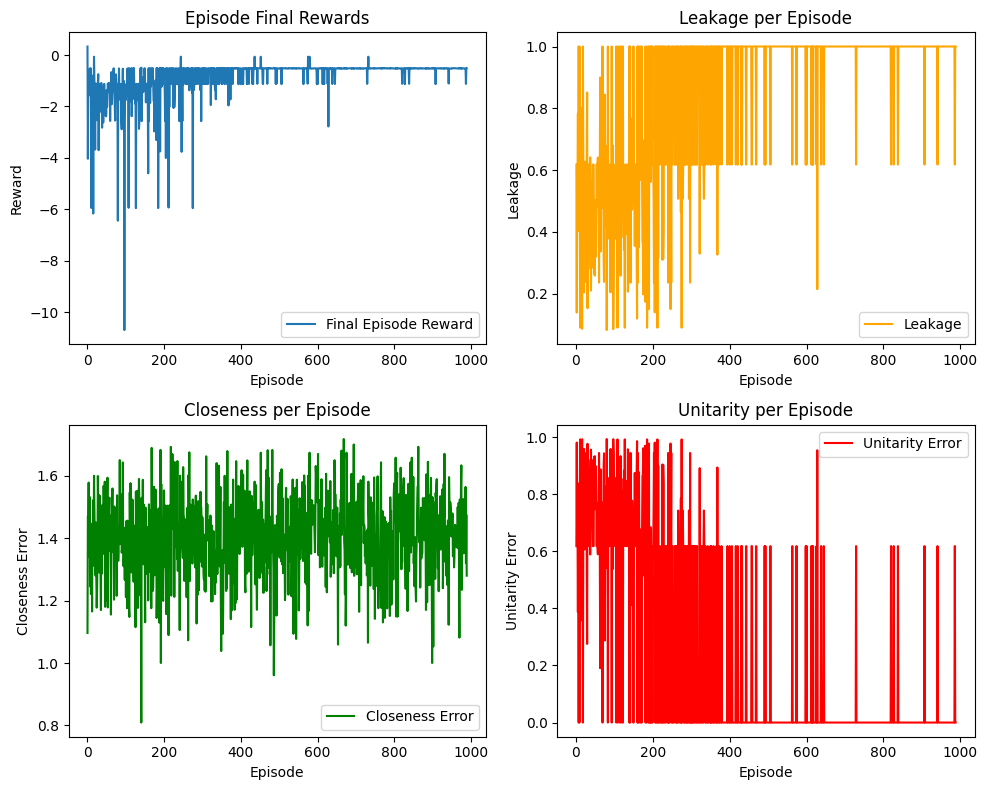

In [345]:
# Plot the main metrics
plot_training_metrics(info_callback)

# Compute accuracy or coverage measure
#acc_90 = compute_accuracy(info_callback, fidelity_threshold=0.9)
#acc_95 = compute_accuracy(info_callback, fidelity_threshold=0.95)
#print(f"Accuracy for fidelity >= 0.95: {acc_95 * 100:.1f}%")
##print(f"Accuracy for fidelity >= 0.90: {acc_90 * 100:.1f}%")


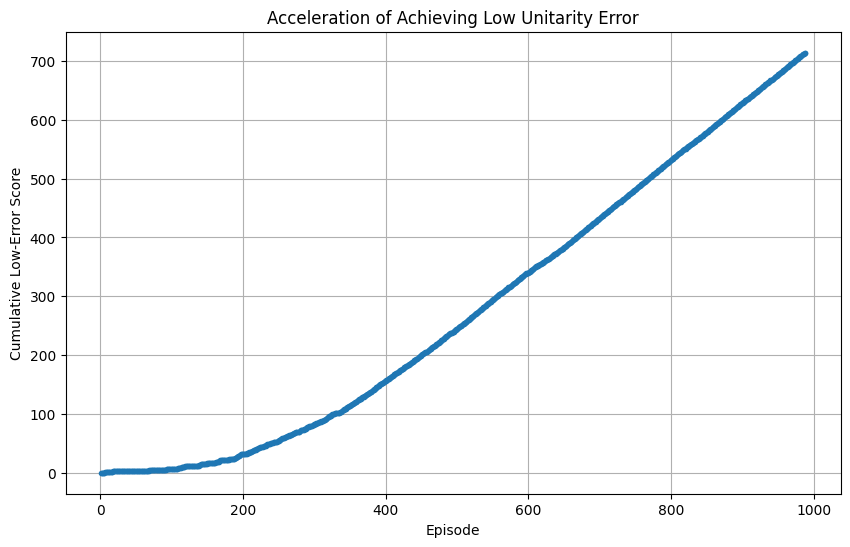

In [346]:
import numpy as np
import matplotlib.pyplot as plt

def plot_low_unitary_acceleration(callback, threshold=0.001, increment=1.0):
    # Convert the unitarity log into a NumPy array.
    errors = np.array(callback.unitarity_log)
    num_episodes = len(errors)
    
    # Initialize the cumulative array.
    cumulative = np.zeros(num_episodes)
    
    # For each episode, if the unitarity error is below threshold,
    # subtract 'decrement' from the cumulative value.
    for i in range(num_episodes):
        if i > 0:
            cumulative[i] = cumulative[i-1]
        if errors[i] < threshold:
            cumulative[i] += increment

    episodes = np.arange(1, num_episodes + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, cumulative, marker='.', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Low-Error Score")
    plt.title("Acceleration of Achieving Low Unitarity Error")
    plt.grid(True)
    plt.show()

# Example usage:
plot_low_unitary_acceleration(info_callback, threshold=0.0000000000001, increment=1.0)


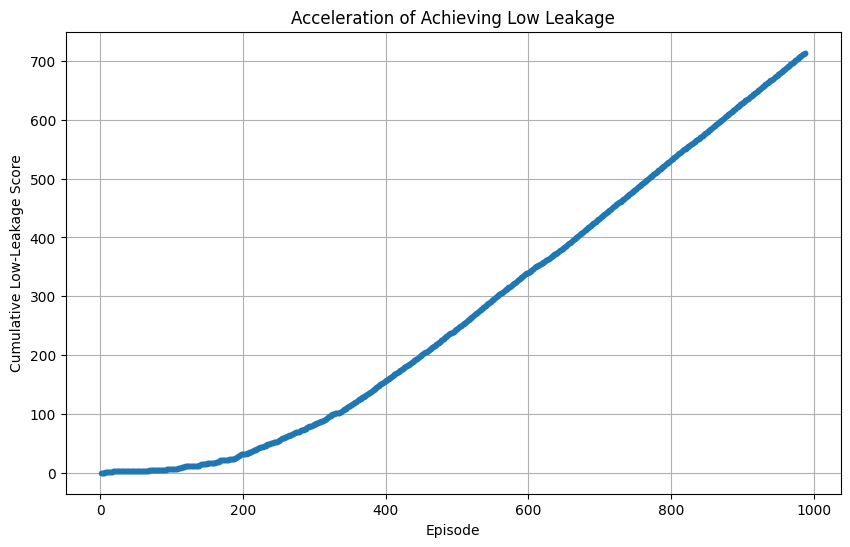

In [347]:
import numpy as np
import matplotlib.pyplot as plt

def plot_low_leakage_acceleration(callback, threshold=0.9, increment=1.0):
    """
    Plots a cumulative metric for achieving low leakage.
    
    The cumulative score starts at 0 and is decremented by `decrement` every time
    an episode's leakage (from callback.leakage_log) falls below the specified threshold.
    
    A steeper downward slope indicates that low-leakage episodes are occurring more frequently.
    
    Parameters:
        callback: An object (e.g., your InfoCallback) that contains a list `leakage_log`
                  with leakage values (typically computed as abs(M[0,0])) for each episode.
        threshold: A float. An episode is considered a success if its leakage is below this value.
                   (Default: 0.05)
        decrement: The fixed amount subtracted from the cumulative score each time a low-leakage
                   episode occurs. (Default: 1.0)
    """
    # Get leakage errors as a NumPy array.
    leakage_errors = np.array(callback.leakage_log)
    num_episodes = len(leakage_errors)
    
    # Initialize the cumulative score array.
    cumulative = np.zeros(num_episodes)
    
    # For each episode, if leakage is below the threshold, decrement the cumulative score.
    for i in range(num_episodes):
        if i > 0:
            cumulative[i] = cumulative[i-1]
        if leakage_errors[i] > threshold:
            cumulative[i] += increment

    episodes = np.arange(1, num_episodes + 1)
    
    # Plot the cumulative score.
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, cumulative, marker='.', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Low-Leakage Score")
    plt.title("Acceleration of Achieving Low Leakage")
    plt.grid(True)
    plt.show()

# Example usage:
plot_low_leakage_acceleration(info_callback, threshold=0.9, increment=1.0)

In [350]:
def evaluate_policy_vec(env, model, num_sequences):
    SEQUENCE_LENGTH = getattr(env, 'max_length', 10)
    max_operator_width = SEQUENCE_LENGTH
    operator_column_width = max(max_operator_width, 10)

    print(f"{'Closeness':<10} | {'Leakage':<10} | {'Unitarity':<10} | {'Operator':<{operator_column_width}}")
    print("-" * (operator_column_width + 34))

    # Reset all parallel environments at once
    obs = env.reset()  # <--- single return value only

    episodes_collected = 0

    while episodes_collected < num_sequences:
        actions, _ = model.predict(obs, deterministic=False)
        #print(len(env.step(actions)))
        obs, _, dones, infos = env.step(actions)

        for i in range(env.num_envs):
            if dones[i]:
                episodes_collected += 1
                gate_stack = infos[i].get("gate_stack", [])
                operator_string = ''.join(map(str, gate_stack))

                closeness_error = infos[i].get("closeness_error", 9999)
                leakage = infos[i].get("leakage", 0.0)
                unitarity_error = infos[i].get("unitarity_error", 9999)

                #if True:
                #if  and len(operator_string) > 5:
                if (leakage > 0.99) and (unitarity_error < 0.000000000000001):
                    print(f"{closeness_error:<10.4e} | "
                          f"{leakage:<10.3f} | "
                          f"{unitarity_error:<10.3e}"
                          f"{operator_string:<{operator_column_width}}")

                if episodes_collected >= num_sequences:
                    break

        if episodes_collected >= num_sequences:
            break


In [351]:
evaluate_policy_vec(vec_env, model, num_sequences=1000)

Closeness  | Leakage    | Unitarity  | Operator  
--------------------------------------------
1.6739e+00 | 1.000      | 8.908e-16 503       
1.5997e+00 | 1.000      | 3.691e-17 4         
1.5811e+00 | 1.000      | 6.771e-16 6         
1.5997e+00 | 1.000      | 4.995e-16 389       
1.3004e+00 | 1.000      | 7.787e-16 044       
1.3450e+00 | 1.000      | 9.813e-16 0964      
1.4976e+00 | 1.000      | 7.779e-16 455304    
1.5315e+00 | 1.000      | 6.829e-16 456       
1.6648e+00 | 1.000      | 4.526e-16 40543400  
1.5811e+00 | 1.000      | 5.396e-16 010       
1.1506e+00 | 1.000      | 8.097e-16 4898      
1.3932e+00 | 1.000      | 9.515e-16 46114     
1.3366e+00 | 1.000      | 8.892e-16 14        
1.5811e+00 | 1.000      | 8.908e-16 1         
1.3434e+00 | 1.000      | 8.932e-16 0403461335684
1.6236e+00 | 1.000      | 6.667e-16 0300      
1.6760e+00 | 1.000      | 3.691e-17 0         
1.7145e+00 | 1.000      | 8.301e-16 340       
1.4142e+00 | 1.000      | 2.606e-16 0400      
1.6739e+0

In [109]:
def construct_gate_from_string(string_of_numbers, env):

    test_gate = [ch for ch in string_of_numbers]

    for i in test_gate:
        env.take_action(int(i))

    return env


In [110]:

test = ["30",
        "880",
        "5300",
        "48440",
        "553000",
        "4334300",
        "37770000",
        "441001048",
        "2555337582",
        "59672955693",
        "374050007970",
        "306947382105",
        "6595888969003",
        "75139699757375",
        "78450807782427077787",
        "287430798424700981936977"
        ]
"""
test = [
    "000",
    "0000",
    "00000",
    "222000",
    "0000000",
    "00000000",
    "000000000",
    "2221001222",
    "22210012220",
    "223443100122",
    "2213404301242",
    "34224334310031224",
    "242314040312211412221",
    "422211222020214000112021",
    "101422102223130431111322222",
    "31423322434332420442310301422",
    "222223043422422024043333320003",
    "2344130440331032213334400344312",
    "423330314001220244224333334034032",
    "132424244140142042111112011202122020400",
    "231333001244422220433403402422343302043"
]
"""

'\ntest = [\n    "000",\n    "0000",\n    "00000",\n    "222000",\n    "0000000",\n    "00000000",\n    "000000000",\n    "2221001222",\n    "22210012220",\n    "223443100122",\n    "2213404301242",\n    "34224334310031224",\n    "242314040312211412221",\n    "422211222020214000112021",\n    "101422102223130431111322222",\n    "31423322434332420442310301422",\n    "222223043422422024043333320003",\n    "2344130440331032213334400344312",\n    "423330314001220244224333334034032",\n    "132424244140142042111112011202122020400",\n    "231333001244422220433403402422343302043"\n]\n'

In [111]:

# Instantiate environment and model
env = GateApproxEnv(
    braid_gates=braid_gates,
    target_gate=target_gate,
    subs=subs,
    max_length=SEQUENCE_LENGTH,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA,
    local_equivalence_class=False
)


# Determine the maximum width of the Operator column dynamically
max_operator_width = max(len(str(t)) for t in test)
operator_column_width = max(max_operator_width, 10)  # At least 10 for aesthetics

# Print table header with dynamically adjusted width
print(f"{'Operator':<{operator_column_width}} | {'Closeness':<10} | {'Leakage':<10} | {'Unitarity':<10}")
print("-" * (operator_column_width + 34))  # Adjust divider length based on width

# Iterate over the test cases and compute metrics
for t in test:
    env.reset_composition()
    gate_object = construct_gate_from_string(t, env)
    leakage, unitarity_error, closeness_error, total_error = gate_object.compute_reward()

    if unitarity_error < 0.0001:
        unitarity_error = 0.0

    # Print the results in a clean tabular format with dynamic width
    print(f"{t:<{operator_column_width}} | {closeness_error:<10.3e} | {leakage:<10.3f} | {unitarity_error:<10.3e}")


Operator                 | Closeness  | Leakage    | Unitarity 
----------------------------------------------------------
30                       | 8.092e-01  | 1.000      | 0.000e+00 


IndexError: list index out of range